In [1]:
import numpy as np
import matplotlib.pyplot as plt
# use times new roman font
plt.rcParams["font.family"] = "Times New Roman"

import scipy
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import ipywidgets as widgets
from ipywidgets import interact

2024-10-11 13:36:31.003756: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 13:36:31.004601: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 13:36:31.006422: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 13:36:31.011489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 13:36:31.019945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

I0000 00:00:1728668192.216387 4173561 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-11 13:36:32.216775: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


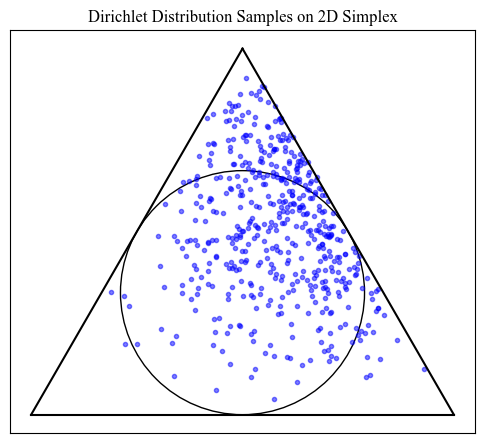

In [2]:
# Parameters for the Dirichlet distribution
alpha = np.array([1.0, 2.0, 3.0])  # Example concentration parameters

samples = tfd.Dirichlet(alpha).sample(500).numpy()

# Function to plot the 2D simplex
def plot_dirichlet_on_simplex(samples, radius = None):
    fig, ax = plt.subplots(figsize=(6, 6))
    # Define the vertices of an equilateral triangle (the simplex)
    simplex = np.array([
        [0, 0], 
        [1, 0], 
        [0.5, np.sqrt(3) / 2]])
    
    # Plot the simplex (triangle)
    for i in range(3):
        ax.plot([simplex[i, 0], simplex[(i + 1) % 3, 0]], [simplex[i, 1], simplex[(i + 1) % 3, 1]], 'k-')

    # plot the circle
    if radius:
        circle = plt.Circle((0.5, np.sqrt(3)/6), radius, color='k', fill=False)
        ax.add_artist(circle)
    
    # Convert samples to 2D coordinates for plotting
    points = samples @ simplex

    # Plot the points sampled from the Dirichlet distribution
    ax.scatter(points[:, 0], points[:, 1], alpha=0.5, marker='.', c='b')

    # Set the aspect ratio to make the triangle equilateral
    ax.set_aspect('equal')
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.title('Dirichlet Distribution Samples on 2D Simplex')
    plt.show()

# Plot the samples on the simplex
plot_dirichlet_on_simplex(samples, radius=np.sqrt(3)/6)

In [3]:
# Function to reparameterize and visualize the Dirichlet distribution with sliders
def reparameterized_dirichlet(phi, par_1, par_2, par_3):
    conc = np.array([par_1, par_2, par_3])

    conc_norm = np.exp(conc) / np.sum(np.exp(conc))

    print('Concentration parameters:', conc_norm)
    
    # Reparameterized alpha (center * phi)
    alpha = phi * conc_norm
    
    # Generate samples from the reparameterized Dirichlet distribution
    samples = tfd.Dirichlet(alpha).sample(500).numpy()
    
    # Plot the samples on the 2D simplex
    plot_dirichlet_on_simplex(samples)

# Sliders to manipulate phi and center values
phi_slider = widgets.FloatSlider(value=20, min=1, max=40, step=2, description=r'phi')
par_1_slider = widgets.FloatSlider(value=0, min=0, max=3, step=.5, description='par 1%')
par_2_slider = widgets.FloatSlider(value=0, min=0, max=3, step=.5, description='par 2%')
par_3_slider = widgets.FloatSlider(value=0, min=0, max=3, step=.5, description='par 3%')

# Interactive plot with sliders
interact(reparameterized_dirichlet, phi=phi_slider, par_1=par_1_slider, par_2=par_2_slider, par_3 = par_3_slider)


interactive(children=(FloatSlider(value=20.0, description='phi', max=40.0, min=1.0, step=2.0), FloatSlider(val…

<function __main__.reparameterized_dirichlet(phi, par_1, par_2, par_3)>

In [4]:
# Reparameterized lower control variable
def compute_center(theta, radius_scale = 0.5, normalize = True):
    num_states = 3

    max_radius_3d = np.sqrt(3)/6 * num_states if normalize else np.sqrt(3)/6

    center_1 = 1/3 + max_radius_3d * radius_scale * np.cos(theta)
    center_2 = 1/3 + max_radius_3d * radius_scale * np.sin(theta)
    center_3 = 1 - (center_1 + center_2)
    
    conc_cent = np.array([center_1, center_2, center_3])
    
    # normalized with softmax
    cent_norm = np.exp(conc_cent) / np.sum(np.exp(conc_cent))

    return cent_norm if normalize else conc_cent

# Function to plot the reparameterized Dirichlet distribution
def plot_reparameterized_dirichlet(theta, phi, radius_scale=0.5, normalize=True):
    center = compute_center(theta, radius_scale, normalize=normalize)
    print('Center:', center, "✅") if sum(center) == 1 else print('Center:', center, "❌", sum(center))
    alpha = phi * center
    print('Alpha: ', alpha)

    samples = tfd.Dirichlet(alpha).sample(500).numpy()
    plot_dirichlet_on_simplex(samples, radius=(np.sqrt(3)/6)*radius_scale)

# Sliders to manipulate theta and phi values
theta_slider = widgets.FloatSlider(value=0, min=0, max=2*np.pi, step=0.2, description=r'theta')
phi_slider = widgets.FloatSlider(value=20, min=0.1, max=30, step=0.1, description=r'phi')
radius_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1, step=0.1, description=r'radius scale')
normalization = widgets.Checkbox(value=True, description='Normalize')

# Interactive plot with sliders
interact(plot_reparameterized_dirichlet, phi=phi_slider, theta=theta_slider, radius_scale=radius_slider, normalize=normalization)

interactive(children=(FloatSlider(value=0.0, description='theta', max=6.283185307179586, step=0.2), FloatSlide…

<function __main__.plot_reparameterized_dirichlet(theta, phi, radius_scale=0.5, normalize=True)>


<html>

<!-- svg in html -->

</html>